In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score
from tableone import TableOne

In [23]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
labels = np.array(labels)

In [24]:
results = pd.read_csv('../runs/run1/results.csv')
icu = pd.read_csv('../../../physionet.org/files/mimiciv/2.0/icu/icustays.csv')
metadata = pd.read_csv('../../../physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv')

In [25]:
results.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,pred_Enlarged Cardiomediastinum,pred_Fracture,pred_Lung Lesion,pred_Lung Opacity,pred_No Finding,pred_Pleural Effusion,pred_Pleural Other,pred_Pneumonia,pred_Pneumothorax,pred_Support Devices
0,10032725,50331901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028591,0.017011,0.010158,0.117863,0.514910,0.024461,0.000972,0.033867,0.054003,0.674239
1,10032725,55504914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024768,0.015360,0.009065,0.067352,0.641565,0.009994,0.000774,0.021268,0.051336,0.690007
2,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.014533,0.025803,0.029284,0.181185,0.421983,0.050918,0.005211,0.072171,0.019981,0.048930
3,10046166,50051329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023567,0.028461,0.029168,0.158798,0.422949,0.034958,0.006189,0.059293,0.029504,0.123027
4,10046166,51738740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018360,0.026041,0.029416,0.089340,0.603777,0.015223,0.006175,0.039030,0.016694,0.084055


In [26]:
icu.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [27]:
icu.shape

(76943, 8)

In [28]:
metadata.head()

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN


In [29]:
# Filter metadata to get StudyDate
metadata = metadata[['subject_id', 'study_id', 'StudyDate']]

In [30]:
# Convert dates to datetime. 
metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
icu['intime'] = pd.to_datetime(icu['intime'])
icu['outtime'] = pd.to_datetime(icu['outtime'])

In [31]:
# Merge with ICU and filter for all study dates in an ICU stay for the same patient.
metadata_icu = metadata.merge(icu, on='subject_id')
metadata_icu = metadata_icu[(metadata_icu['StudyDate'] >= metadata_icu['intime']) & (metadata_icu['StudyDate'] <= metadata_icu['outtime'])].reset_index(drop=True)

In [32]:
metadata_icu.shape

(54457, 10)

In [33]:
metadata_icu.head()

,subject_id,study_id,StudyDate,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10001884,50376803,2131-01-15,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817
1,10001884,50712381,2131-01-12,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817
2,10001884,56722923,2131-01-13,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817
3,10001884,59305618,2131-01-14,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817
4,10002428,50027225,2156-04-16,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134


In [34]:
metadata_icu.nunique()

subject_id        10057
study_id          47773
StudyDate         22872
hadm_id           11868
stay_id           12896
first_careunit        8
last_careunit         8
intime            12896
outtime           12896
los               12778
dtype: int64

In [35]:
# Drop duplicates on study ID since all patients in this df are in the ICU.
metadata_icu = metadata_icu.drop_duplicates(subset=['study_id'])
metadata_icu.shape

(47773, 10)

In [36]:
metadata_icu['study_in_icu'] = 1

In [37]:
metadata_icu_studies = metadata_icu[['study_id', 'study_in_icu']]

In [38]:
results_icu = results.merge(metadata_icu_studies, on='study_id', how='left')
results_icu['study_in_icu'].fillna(0, inplace=True)
results_icu['study_in_icu'].value_counts()

0.0    4191
1.0     968
Name: study_in_icu, dtype: int64

In [39]:
# Helper functions for evaluating model performance
def generate_CI(y_true, y_pred):
#     print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

    n_bootstraps = 1000
    rng_seed = 2021  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    #95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    ci_str = '[{}, {}]'.format(str(round(confidence_lower, 3)), str(round(confidence_upper, 3)))
    return ci_str


def calc_roc(df, strata, labels):

    fpr = {}
    tpr = {}
    auc = {}

    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])

        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')


        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)

            ytrue = tmp[lab]
            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc

            tci = generate_CI(ytrue, ypred)

            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc=4)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

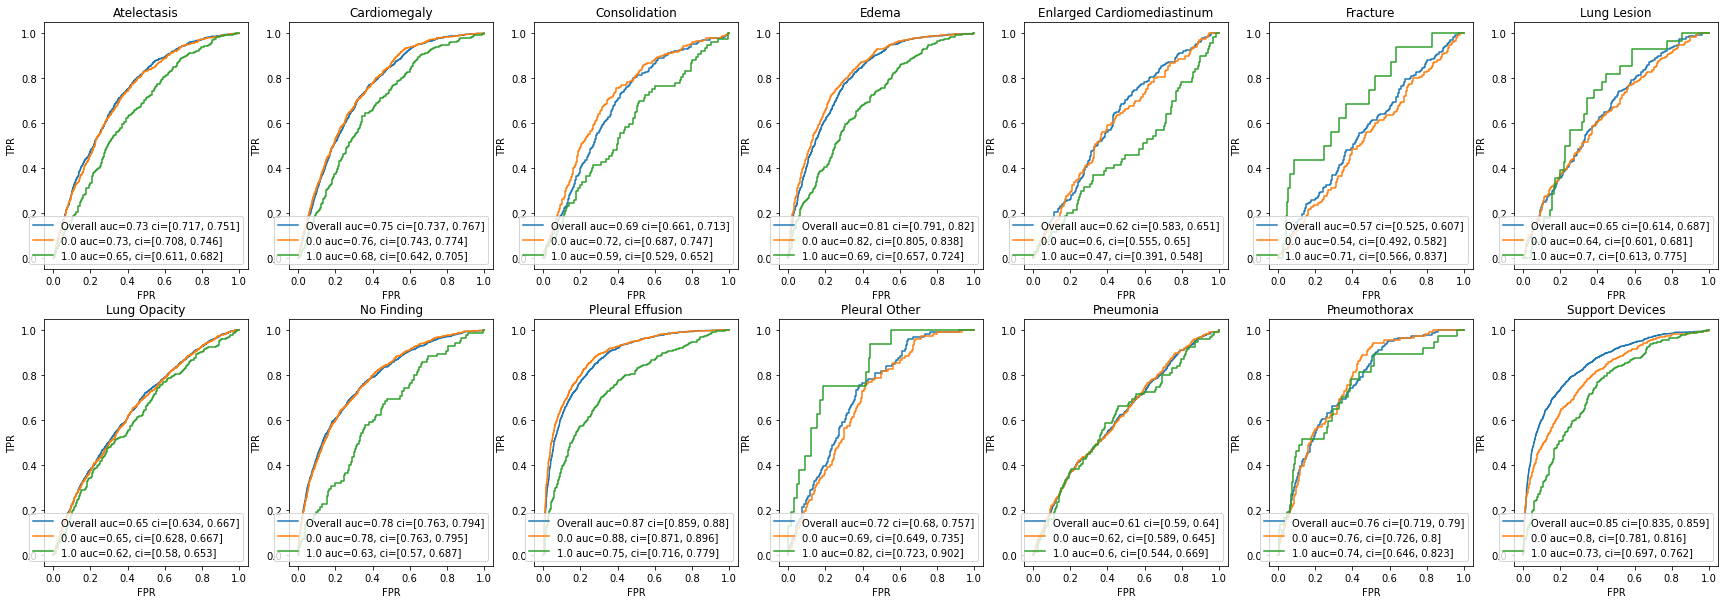

In [40]:
calc_roc(results_icu, 'study_in_icu', labels)

In [45]:
cols = list(labels)
cat = list(labels)
groupby = 'study_in_icu'
tab = TableOne(results_icu, columns=cols, categorical=cat, groupby=groupby, missing=False, pval=True)

In [46]:
tab

Grouped by study_in_icu                                 
                                                      Overall          0.0         1.0 P-Value
n                                                        5159         4191         968        
Atelectasis, n (%)                0.0             4125 (80.0)  3496 (83.4)  629 (65.0)  <0.001
                                  1.0             1034 (20.0)   695 (16.6)  339 (35.0)        
Cardiomegaly, n (%)               0.0             3901 (75.6)  3290 (78.5)  611 (63.1)  <0.001
                                  1.0             1258 (24.4)   901 (21.5)  357 (36.9)        
Consolidation, n (%)              0.0             4833 (93.7)  3942 (94.1)  891 (92.0)   0.025
                                  1.0               326 (6.3)    249 (5.9)    77 (8.0)        
Edema, n (%)                      0.0             4200 (81.4)  3522 (84.0)  678 (70.0)  <0.001
                                  1.0              959 (18.6)   669 (16.0)  290 (30.0)        
Enlarged Cardiomediastinum, n (%) 0.0             4959 (96.1)  4061 (96.9)  898 (92.8)  <0.001
                                  1.0               200 (3.9)    130 (3.1)    70 (7.2)        
Fracture, n (%)                   0.0             4992 (96.8)  4040 (96.4)  952 (98.3)   0.003
                                  1.0               167 (3.2)    151 (3.6)    16 (1.7)        
Lung Lesion, n (%)                0.0             4957 (96.1)  4017 (95.8)  940 (97.1)   0.084
                                  1.0               202 (3.9)    174 (4.2)    28 (2.9)        
Lung Opacity, n (%)               0.0             3598 (69.7)  3015 (71.9)  583 (60.2)  <0.001
                                  1.0             1561 (30.3)  1176 (28.1)  385 (39.8)        
No Finding, n (%)                 0.0             4175 (80.9)  3292 (78.5)  883 (91.2)  <0.001
                                  1.0              984 (19.1)   899 (21.5)    85 (8.8)        
Pleural Effusion, n (%)           0.0             3617 (70.1)  3128 (74.6)  489 (50.5)  <0.001
                                  1.0             1542 (29.9)  1063 (25.4)  479 (49.5)        
Pleural Other, n (%)              0.0             5040 (97.7)  4088 (97.5)  952 (98.3)   0.166
                                  1.0               119 (2.3)    103 (2.5)    16 (1.7)        
Pneumonia, n (%)                  0.0             4620 (89.6)  3746 (89.4)  874 (90.3)   0.439
                                  1.0              539 (10.4)   445 (10.6)    94 (9.7)        
Pneumothorax, n (%)               0.0             5015 (97.2)  4084 (97.4)  931 (96.2)   0.040
                                  1.0               144 (2.8)    107 (2.6)    37 (3.8)        
Support Devices, n (%)            0.0             3702 (71.8)  3397 (81.1)  305 (31.5)  <0.001
                                  1.0             1457 (28.2)   794 (18.9)  663 (68.5)